In [65]:
import pandas as pd
import sklearn
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, accuracy_score
from scipy.stats import randint, uniform
from joblib import dump
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

seed=123

In [60]:
data = pd.read_csv("data/credit_risk_dataset.csv")
data.head()


person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [62]:
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [63]:
data = data.drop_duplicates()
data = data.dropna()
data.isnull().sum()


person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

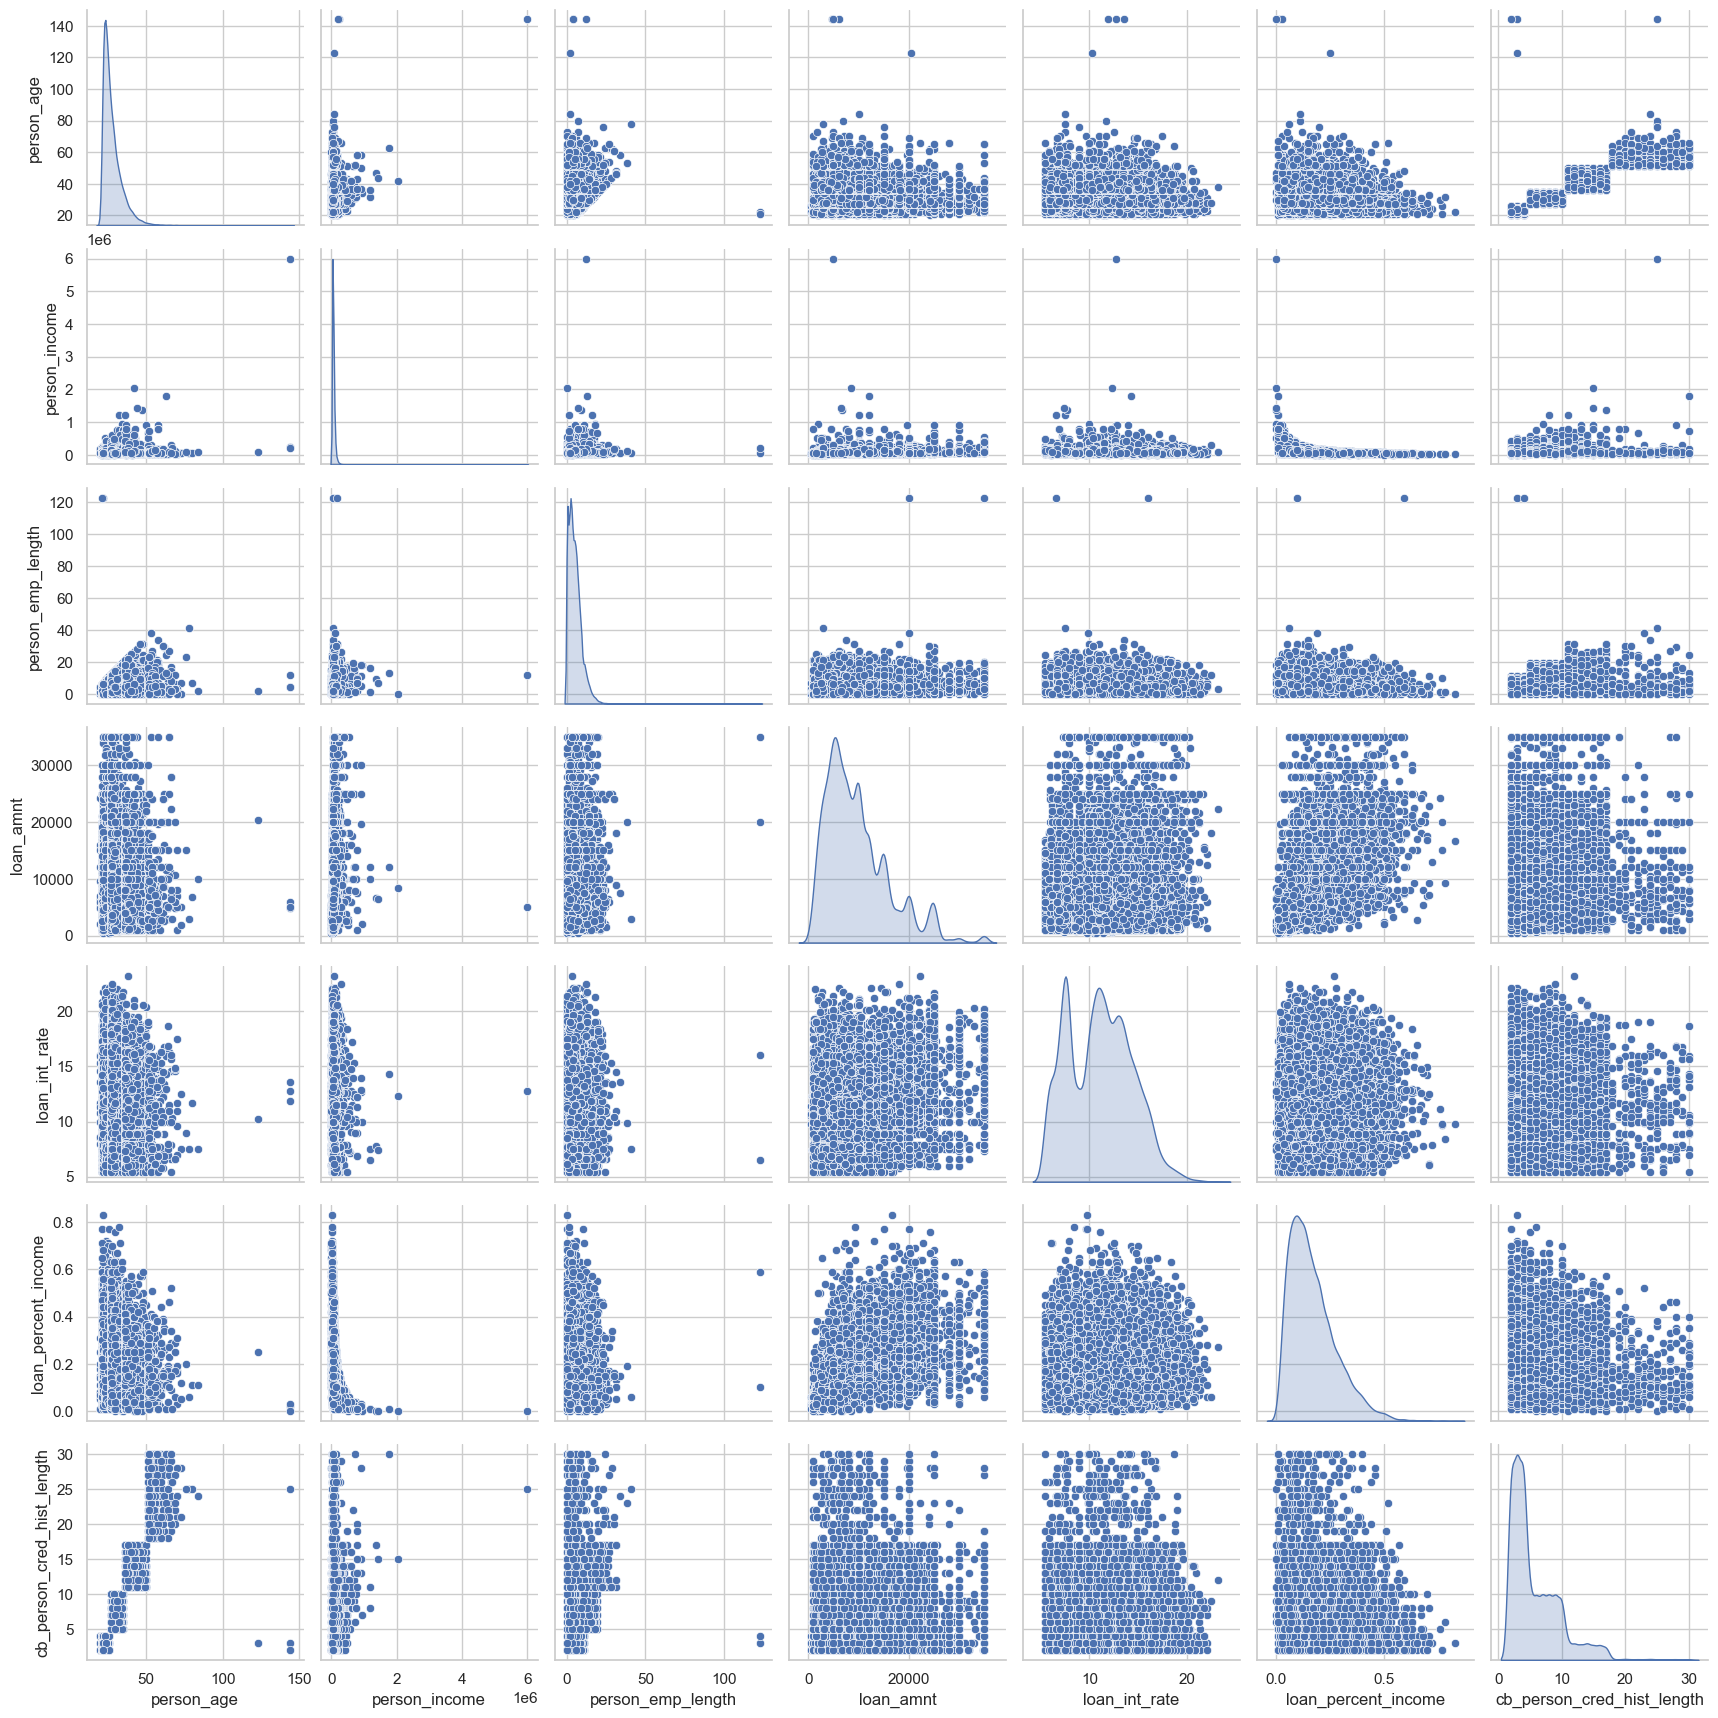

In [68]:
sns.set(style="whitegrid")

numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
sns.pairplot(data[numerical_cols].dropna(), diag_kind='kde')
plt.show()

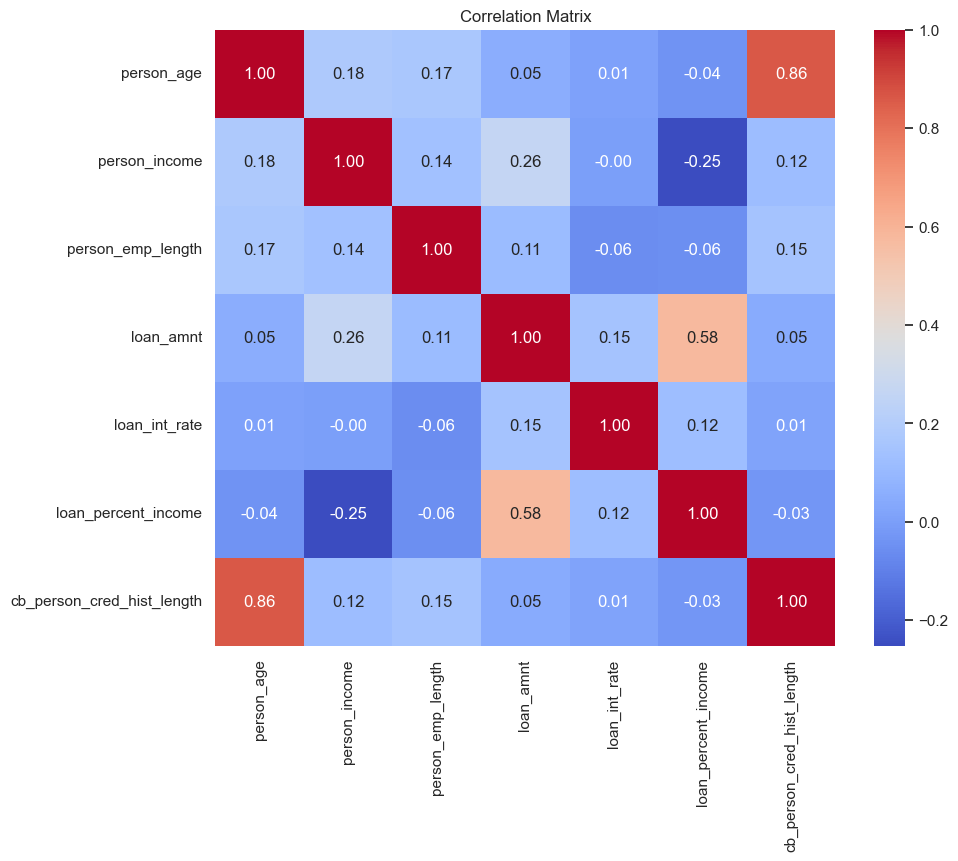

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

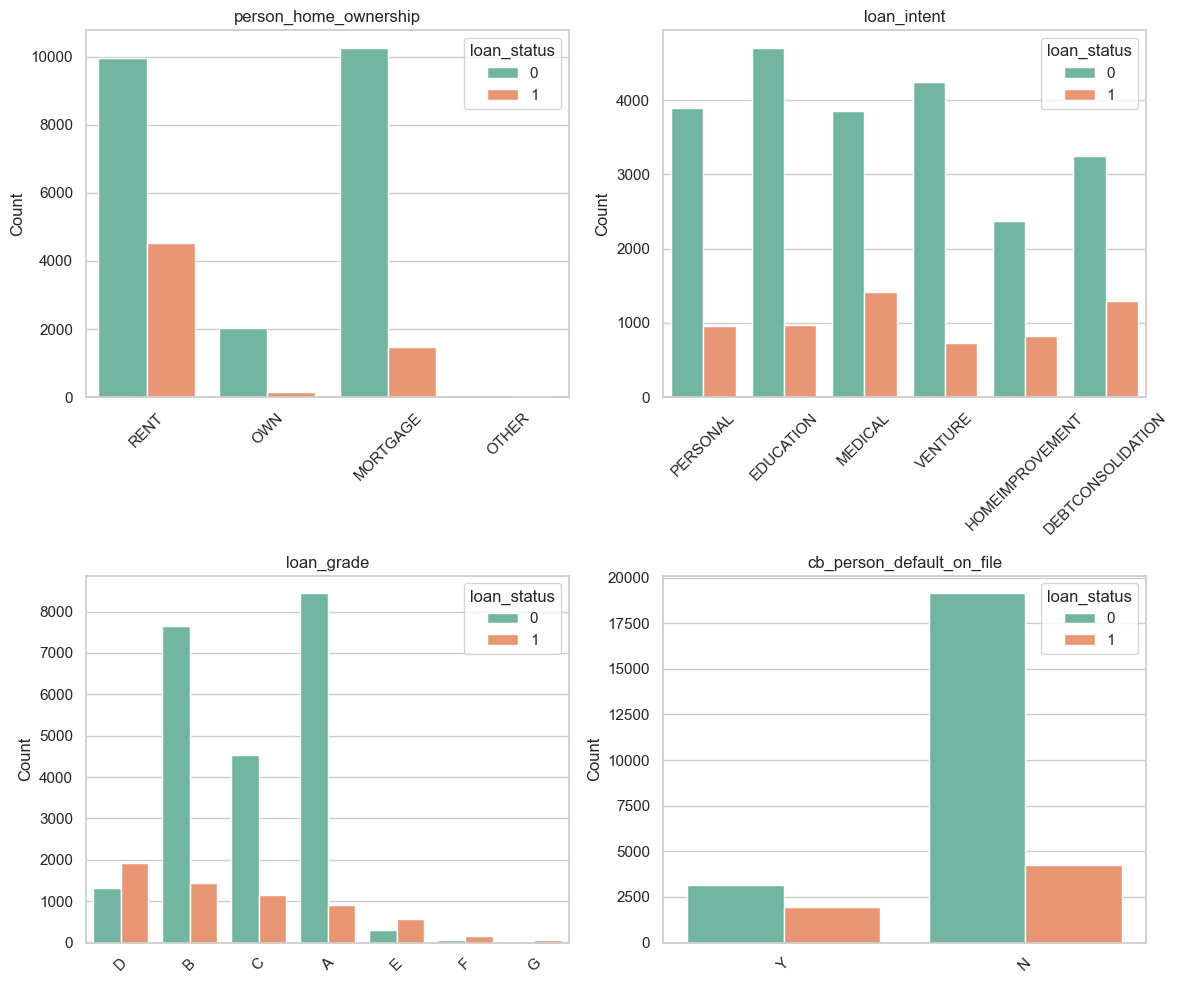

In [70]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
plt.figure(figsize=(12, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=data, x=col, hue='loan_status', palette='Set2')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

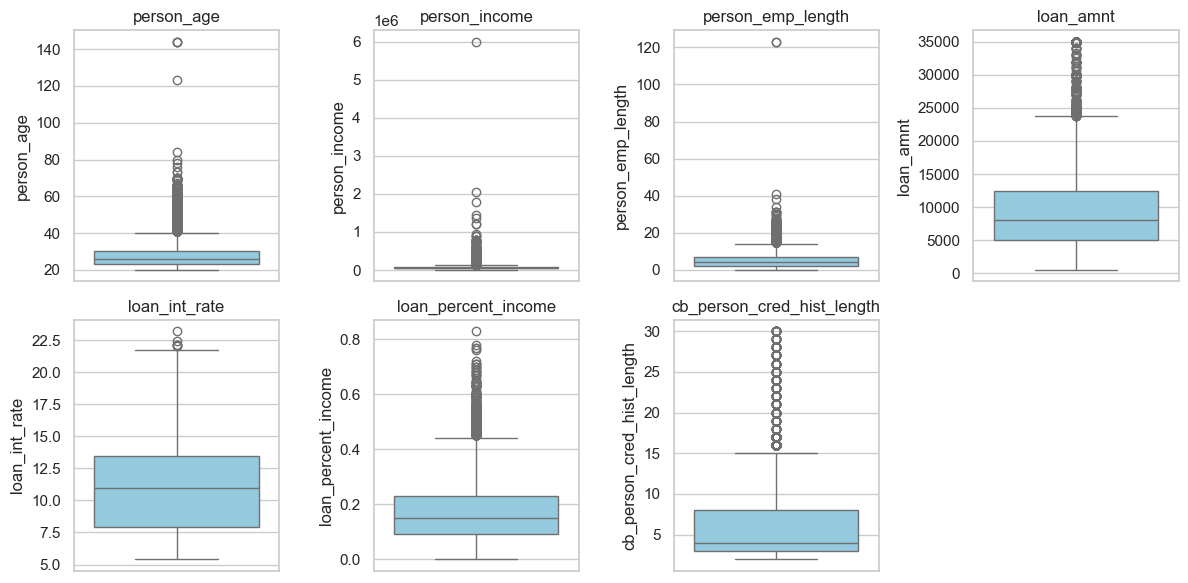

In [87]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data=data[col].dropna(), color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

In [7]:
for column in data.select_dtypes(include=['object']).columns:
    print(column)
    print(data[column].unique())

person_home_ownership
['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent
['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade
['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file
['Y' 'N']


In [8]:
label = data['loan_status']
data.drop(['loan_status'], axis=1, inplace=True)
data = pd.get_dummies(data, columns=['person_home_ownership', 'loan_intent'])
mapping = {
    'A': 0, 
    'B': 1, 
    'C': 2, 
    'D': 3, 
    'E': 4, 
    'F': 5, 
    'G': 6, 
    }
data['loan_grade'] = data['loan_grade'].map(mapping)
mapping1 = {
    'N': 0, 
    'Y': 1, 
    }
data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map(mapping1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28501 entries, 0 to 32580
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      28501 non-null  int64  
 1   person_income                   28501 non-null  int64  
 2   person_emp_length               28501 non-null  float64
 3   loan_grade                      28501 non-null  int64  
 4   loan_amnt                       28501 non-null  int64  
 5   loan_int_rate                   28501 non-null  float64
 6   loan_percent_income             28501 non-null  float64
 7   cb_person_default_on_file       28501 non-null  int64  
 8   cb_person_cred_hist_length      28501 non-null  int64  
 9   person_home_ownership_MORTGAGE  28501 non-null  bool   
 10  person_home_ownership_OTHER     28501 non-null  bool   
 11  person_home_ownership_OWN       28501 non-null  bool   
 12  person_home_ownership_RENT      28501

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

X_test.to_csv('data/test_dataset.csv', index=False)
y_test.to_csv('data/test_dataset_label.csv', index=False)

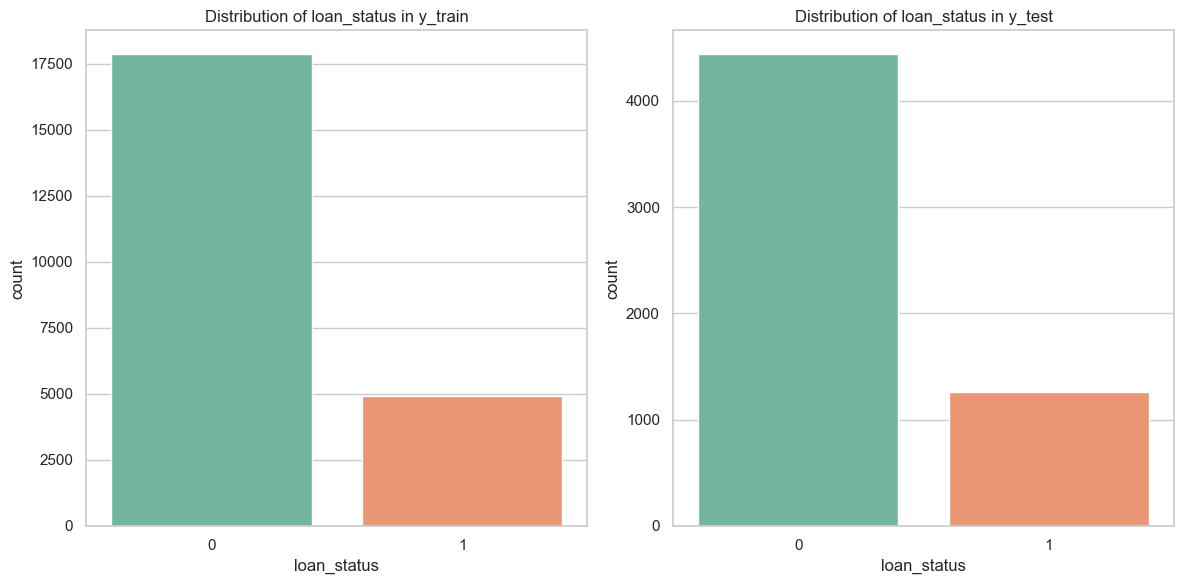

In [81]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette='Set2', hue=y_train, legend=False)
plt.title('Distribution of loan_status in y_train')
plt.subplot(1, 2, 2)
sns.countplot(x=y_test, palette='Set2', hue=y_test, legend=False)
plt.title('Distribution of loan_status in y_test')
plt.tight_layout()
plt.show()


In [39]:
pipeRFC = ImbPipeline([
    ('preprocessing', StandardScaler()),
    ('sampling', RandomUnderSampler()), 
    ('classifier', RandomForestClassifier(random_state=42))
    ])

param_dist_RFC = {
    'preprocessing': [StandardScaler()],
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': [None] + list(randint(10, 50).rvs(10)),
    'classifier__min_samples_split': randint(2, 20), 
    'classifier__min_samples_leaf': randint(1, 4),
    'classifier__max_samples': uniform(0.1, 0.9),
    'classifier__max_leaf_nodes': [None] + list(randint(10, 30).rvs(10)),
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

grid_search_RFC_under = RandomizedSearchCV(estimator=pipeRFC, param_distributions=param_dist_RFC, n_iter=100, cv=kfold, verbose=10, return_train_score=True, scoring='roc_auc')

grid_search_RFC_under.fit(X_train, y_train)
grid_search_RFC_under.best_params_

dump(grid_search_RFC_under.best_estimator_, 'models/RFC_under_model.joblib')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START classifier__class_weight=balanced_subsample, classifier__criterion=entropy, classifier__max_depth=46, classifier__max_leaf_nodes=10, classifier__max_samples=0.24722993428505752, classifier__min_samples_leaf=3, classifier__min_samples_split=7, classifier__n_estimators=225, preprocessing=StandardScaler()
[CV 1/5; 1/100] END classifier__class_weight=balanced_subsample, classifier__criterion=entropy, classifier__max_depth=46, classifier__max_leaf_nodes=10, classifier__max_samples=0.24722993428505752, classifier__min_samples_leaf=3, classifier__min_samples_split=7, classifier__n_estimators=225, preprocessing=StandardScaler();, score=(train=0.900, test=0.898) total time=   0.8s
[CV 2/5; 1/100] START classifier__class_weight=balanced_subsample, classifier__criterion=entropy, classifier__max_depth=46, classifier__max_leaf_nodes=10, classifier__max_samples=0.24722993428505752, classifier__min_samples_leaf=3, cl

['RFC_model_under.joblib']

In [40]:
pipeRFC = ImbPipeline([
    ('preprocessing', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
    ])

param_dist_RFC = {
    'preprocessing': [StandardScaler()],
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': [None] + list(randint(10, 50).rvs(10)),
    'classifier__min_samples_split': randint(2, 20), 
    'classifier__min_samples_leaf': randint(1, 4),
    'classifier__max_samples': uniform(0.1, 0.9),
    'classifier__max_leaf_nodes': [None] + list(randint(10, 30).rvs(10)),
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

grid_search_RFC = RandomizedSearchCV(estimator=pipeRFC, param_distributions=param_dist_RFC, n_iter=100, cv=kfold, verbose=10, return_train_score=True, scoring='roc_auc')

grid_search_RFC.fit(X_train, y_train)
grid_search_RFC.best_params_

dump(grid_search_RFC.best_estimator_, 'models/RFC_model.joblib')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START classifier__class_weight=balanced_subsample, classifier__criterion=gini, classifier__max_depth=33, classifier__max_leaf_nodes=10, classifier__max_samples=0.6985739233005361, classifier__min_samples_leaf=3, classifier__min_samples_split=15, classifier__n_estimators=243, preprocessing=StandardScaler()
[CV 1/5; 1/100] END classifier__class_weight=balanced_subsample, classifier__criterion=gini, classifier__max_depth=33, classifier__max_leaf_nodes=10, classifier__max_samples=0.6985739233005361, classifier__min_samples_leaf=3, classifier__min_samples_split=15, classifier__n_estimators=243, preprocessing=StandardScaler();, score=(train=0.900, test=0.896) total time=   2.1s
[CV 2/5; 1/100] START classifier__class_weight=balanced_subsample, classifier__criterion=gini, classifier__max_depth=33, classifier__max_leaf_nodes=10, classifier__max_samples=0.6985739233005361, classifier__min_samples_leaf=3, classifier__

['RFC_model.joblib']

In [41]:
xgb_pipeline = ImbPipeline([
    ('preprocessing', StandardScaler()),
    ('sampling', RandomUnderSampler()), 
    ('classifier', XGBClassifier(random_state=42))  
])

param_dist_XGB = {
    'classifier__learning_rate': uniform(0.01, 0.5),
    'classifier__max_depth': randint(3, 10),
    'classifier__n_estimators': randint(100, 1000),
    'classifier__min_child_weight': uniform(1, 10),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__gamma': uniform(0, 0.5)
}

grid_search_xgb_under = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=param_dist_XGB, n_iter=100, cv=kfold, verbose=10, scoring='roc_auc', random_state=42)
grid_search_xgb_under.fit(X_train, y_train)
grid_search_xgb_under.best_params_

dump(grid_search_xgb_under.best_estimator_, 'models/xgb_under_model.joblib') 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START classifier__colsample_bytree=0.749816047538945, classifier__gamma=0.4753571532049581, classifier__learning_rate=0.37599697090570255, classifier__max_depth=7, classifier__min_child_weight=6.96850157946487, classifier__n_estimators=221, classifier__subsample=0.662397808134481
[CV 1/5; 1/100] END classifier__colsample_bytree=0.749816047538945, classifier__gamma=0.4753571532049581, classifier__learning_rate=0.37599697090570255, classifier__max_depth=7, classifier__min_child_weight=6.96850157946487, classifier__n_estimators=221, classifier__subsample=0.662397808134481;, score=0.931 total time=   0.2s
[CV 2/5; 1/100] START classifier__colsample_bytree=0.749816047538945, classifier__gamma=0.4753571532049581, classifier__learning_rate=0.37599697090570255, classifier__max_depth=7, classifier__min_child_weight=6.96850157946487, classifier__n_estimators=221, classifier__subsample=0.662397808134481
[CV 2/5; 1/100]

['xgb_model_under.joblib']

In [42]:
xgb_pipeline = ImbPipeline([
    ('preprocessing', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42))  
])

param_dist_XGB = {
    'classifier__learning_rate': uniform(0.01, 0.5),
    'classifier__max_depth': randint(3, 10),
    'classifier__n_estimators': randint(100, 1000),
    'classifier__min_child_weight': uniform(1, 10),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__gamma': uniform(0, 0.5)
}

grid_search_xgb = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=param_dist_XGB, n_iter=100, cv=kfold, verbose=10, scoring='roc_auc', random_state=42)
grid_search_xgb.fit(X_train, y_train)
grid_search_xgb.best_params_

dump(grid_search_xgb.best_estimator_, 'models/xgb_model.joblib') 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START classifier__colsample_bytree=0.749816047538945, classifier__gamma=0.4753571532049581, classifier__learning_rate=0.37599697090570255, classifier__max_depth=7, classifier__min_child_weight=6.96850157946487, classifier__n_estimators=221, classifier__subsample=0.662397808134481
[CV 1/5; 1/100] END classifier__colsample_bytree=0.749816047538945, classifier__gamma=0.4753571532049581, classifier__learning_rate=0.37599697090570255, classifier__max_depth=7, classifier__min_child_weight=6.96850157946487, classifier__n_estimators=221, classifier__subsample=0.662397808134481;, score=0.938 total time=   0.4s
[CV 2/5; 1/100] START classifier__colsample_bytree=0.749816047538945, classifier__gamma=0.4753571532049581, classifier__learning_rate=0.37599697090570255, classifier__max_depth=7, classifier__min_child_weight=6.96850157946487, classifier__n_estimators=221, classifier__subsample=0.662397808134481
[CV 2/5; 1/100]

['xgb_model.joblib']

In [36]:
voting_clf = VotingClassifier(estimators=[('rf', grid_search_RFC), ('xgb', grid_search_xgb),('rf_under', grid_search_RFC_under),('xgb_under', grid_search_xgb_under)], voting='soft')

voting_clf.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START classifier__class_weight=None, classifier__criterion=gini, classifier__max_depth=15, classifier__max_leaf_nodes=18, classifier__max_samples=0.6911541537649434, classifier__min_samples_leaf=2, classifier__min_samples_split=3, classifier__n_estimators=296, preprocessing=StandardScaler()
[CV 1/5; 1/100] END classifier__class_weight=None, classifier__criterion=gini, classifier__max_depth=15, classifier__max_leaf_nodes=18, classifier__max_samples=0.6911541537649434, classifier__min_samples_leaf=2, classifier__min_samples_split=3, classifier__n_estimators=296, preprocessing=StandardScaler();, score=(train=0.906, test=0.902) total time=   1.8s
[CV 2/5; 1/100] START classifier__class_weight=None, classifier__criterion=gini, classifier__max_depth=15, classifier__max_leaf_nodes=18, classifier__max_samples=0.6911541537649434, classifier__min_samples_leaf=2, classifier__min_samples_split=3, classifier__n_estimator

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

RFC
Accuracy: 0.9308893176635678
Precision: 0.9843400447427293
Recall: 0.6984126984126984
F1: 0.8170844939647168
Roc auc: 0.9309745409835479
Average Precision: 0.8819683365783163

XGB
Accuracy: 0.9343974741273461
Precision: 0.9643605870020965
Recall: 0.7301587301587301
F1: 0.8310749774164409
Roc auc: 0.9445168219655949
Average Precision: 0.9003796005782398

Voting
Accuracy: 0.9252762673215226
Precision: 0.9009615384615385
Recall: 0.7436507936507937
F1: 0.8147826086956522
Roc auc: 0.9417169735116144
Average Precision: 0.8958027240203442

RFC_under
Accuracy: 0.9051043676547974
Precision: 0.7998331943286072
Recall: 0.7611111111111111
F1: 0.7799918666124441
Roc auc: 0.928396114131309
Average Precision: 0.8752087528672908

XGB_under
Accuracy: 0.8966847921417295
Precision: 0.7429398986241854
Recall: 0.8142857142857143
F1: 0.7769784172661871
Roc auc: 0.9418243781788029
Average Precision: 0.8950805070783909



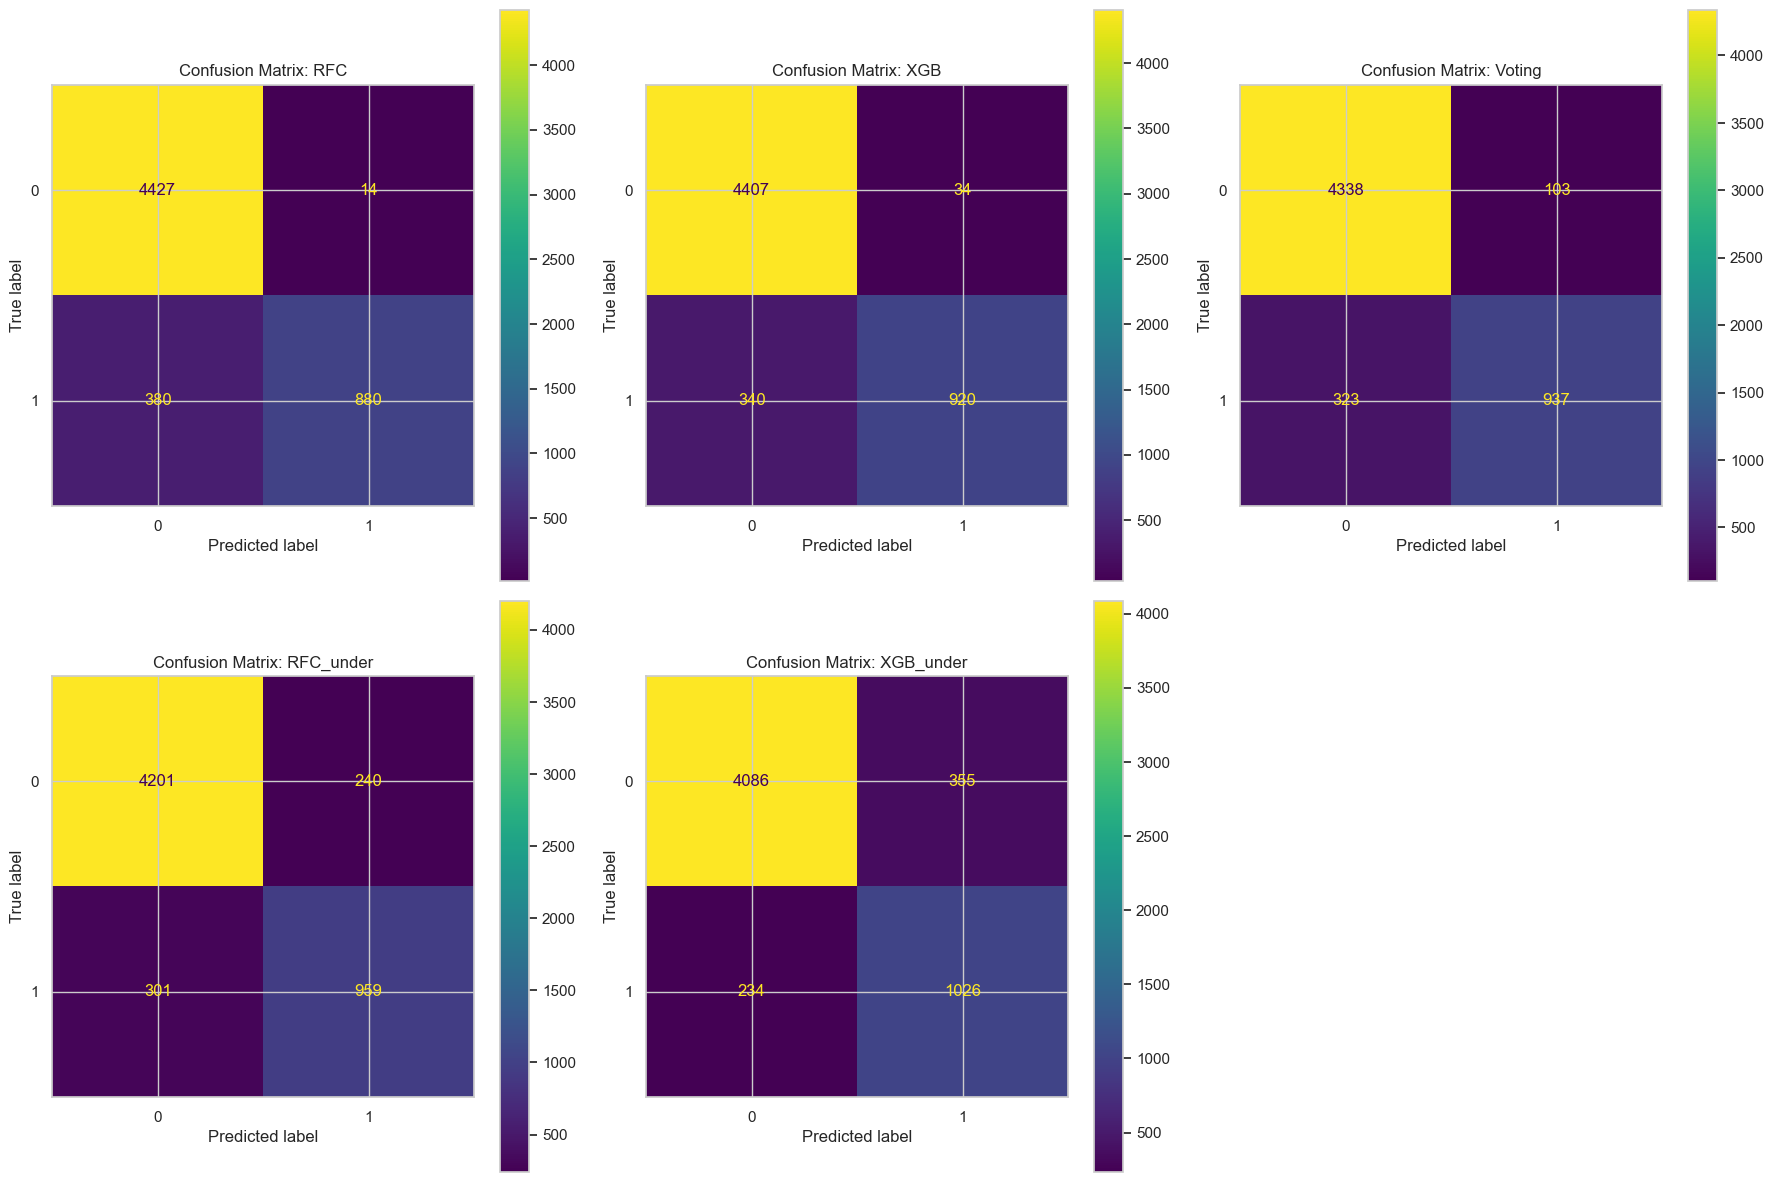

In [98]:

classifiers = {
    'RFC': grid_search_RFC,
    'XGB': grid_search_xgb,
    'Voting': voting_clf,
    'RFC_under': grid_search_RFC_under,
    'XGB_under': grid_search_xgb_under
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for ax, (name, clf) in zip(axes, classifiers.items()):
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    average_precision = average_precision_score(y_test, y_pred_prob)

    print(f"{name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"Roc auc: {roc_auc}")
    print(f"Average Precision: {average_precision}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    ax.set_title(f'Confusion Matrix: {name}')
    
    print()
    
for i in range(len(classifiers), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


RFC
Accuracy: 0.9422368421052632
Precision: 0.9912925170068028
Recall: 0.7392451298701299
F1: 0.8469138672556085
Roc auc: 0.997150098390866
Average Precision: 0.9895843887994397
XGB
Accuracy: 0.9544736842105264
Precision: 0.9911616161616161
Recall: 0.7964691558441559
F1: 0.8832133213321333
Roc auc: 0.9889758936473945
Average Precision: 0.9719324892524628
Voting
Accuracy: 0.9642105263157895
Precision: 0.9587237840249888
Recall: 0.8719561688311688
F1: 0.9132837407013815
Roc auc: 0.9945243171317826
Average Precision: 0.9825177560272152
RFC_under
Accuracy: 0.9350438596491228
Precision: 0.8398737921514494
Recall: 0.8642451298701299
F1: 0.8518851885188519
Roc auc: 0.9799590604253624
Average Precision: 0.9460133637696103
XGB_under
Accuracy: 0.930219298245614
Precision: 0.7955713020372011
Recall: 0.911323051948052
F1: 0.8495223682966045
Roc auc: 0.9816533269319926
Average Precision: 0.9522378409784289


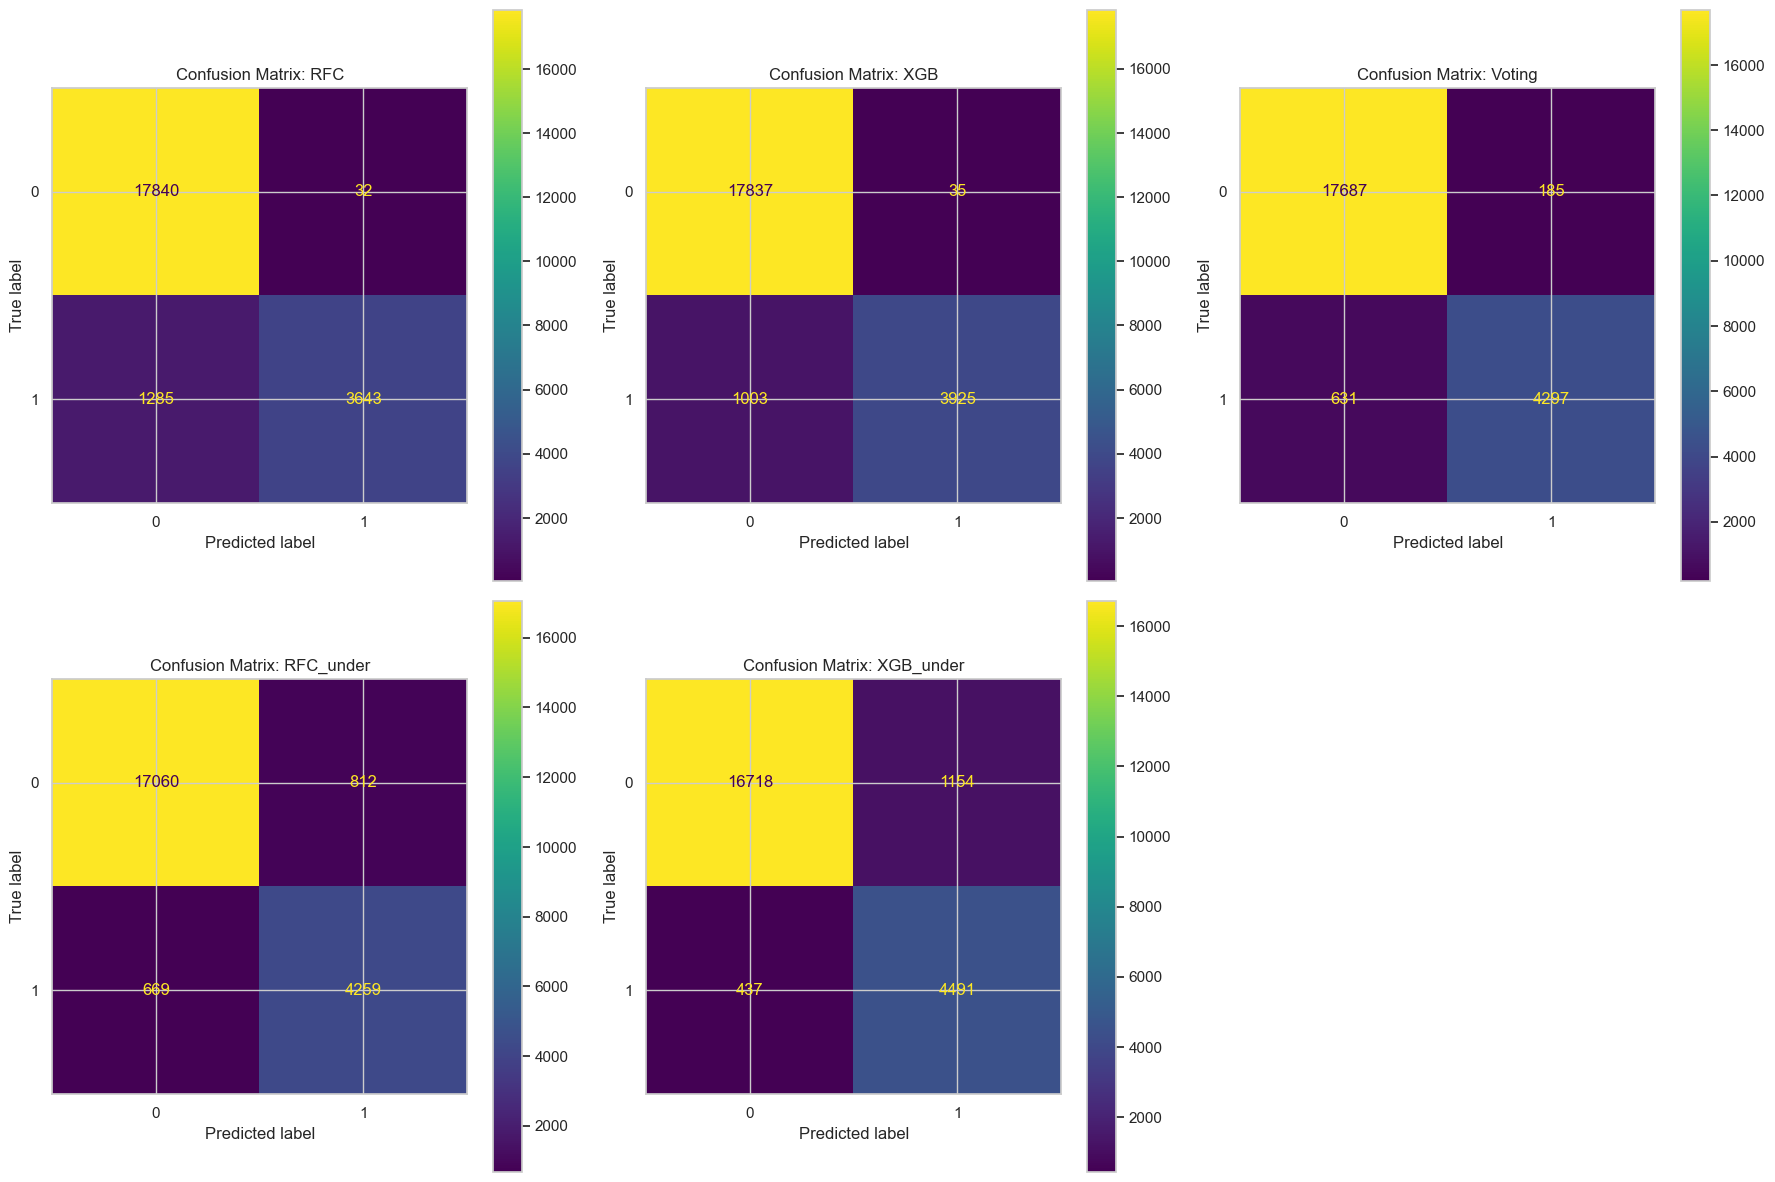

In [92]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for ax, (name, clf) in zip(axes, classifiers.items()):
    y_pred = clf.predict(X_train)
    y_pred_prob = clf.predict_proba(X_train)[:, 1]
    
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred, average='binary')
    roc_auc = roc_auc_score(y_train, y_pred_prob)
    average_precision = average_precision_score(y_train, y_pred_prob)

    print(f"{name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"Roc auc: {roc_auc}")
    print(f"Average Precision: {average_precision}")

    cm = confusion_matrix(y_train, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    ax.set_title(f'Confusion Matrix: {name}')

for i in range(len(classifiers), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()